### 1. Preparación del dataset

#### 1.1. Lectura del conjunto de datos

In [1]:
from scipy.io import loadmat
data=loadmat("Indian_pines_corrected_image.mat")['indian_pines_corrected']
labels=loadmat("Indian_pines_ground_truth.mat")['indian_pines_gt']
H,W,C=data.shape

#### 1.2. Reducción de la dimensionalidad

In [2]:
from sklearn.decomposition import PCA
n_components=22 # Nuestro análisis abarca 20 bandas
data=data.reshape(H*W,C)
pca=PCA(n_components=n_components,whiten=True)
data=pca.fit_transform(data)

#### 1.3. Normalización de los datos

In [3]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
standar_scaler=StandardScaler()
data=standar_scaler.fit_transform(data)
data=data.reshape(H,W,n_components);

#### 1.4. Aproximación parche a pixel

In [4]:
import numpy as np

def padWithZeros(X, margin=2):
    newX=np.zeros((X.shape[0]+2*margin,X.shape[1]+2*margin, X.shape[2]))
    x_offset=margin
    y_offset=margin 
    newX[x_offset:X.shape[0]+x_offset, y_offset:X.shape[1]+y_offset,:]=X
    return newX

def createImageCubes(X,y,windowSize=9, removeZeroLabels=True): 
    margin=int((windowSize-1)/2)
    zeroPaddedX=padWithZeros(X,margin=margin)
    patchesData=np.zeros((X.shape[0]*X.shape[1],windowSize,windowSize,X.shape[2]))
    patchesLabels=np.zeros((X.shape[0]*X.shape[1]))
    patchIndex=0
    for r in range(margin,zeroPaddedX.shape[0]-margin):
        for c in range(margin,zeroPaddedX.shape[1]-margin):
            patch=zeroPaddedX[r-margin:r+margin+1,c-margin:c+margin+1]
            patchesData[patchIndex,:,:,:]=patch 
            patchesLabels[patchIndex]=y[r-margin,c-margin]
            patchIndex=patchIndex+1
    if removeZeroLabels:
        patchesData=patchesData[patchesLabels>0,:,:,:]
        patchesLabels=patchesLabels[patchesLabels>0]
        patchesLabels -=1
    from keras.utils import np_utils
    patchesLabels=np_utils.to_categorical(patchesLabels)
    return patchesData,patchesLabels 

#### 1.5. Acondicionar el conjunto de datos

In [5]:
x_train,y_train=createImageCubes(data,labels,removeZeroLabels=False)

In [6]:
n_clases=y_train.shape[1]

#### 1.6. Partir Dataset

In [7]:
# TEST 40%, TRAIN 48%, VALIDATION 12%
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x_train,y_train,test_size=0.4,shuffle=True,random_state=0,stratify=y_train) 
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=0.2,shuffle=True,random_state=0,stratify=y_train)

### 2. Red Neuronal Convolucional

In [8]:
from tensorflow.keras.layers import Input,Conv2D,Dropout,BatchNormalization,Flatten,Dense,LayerNormalization
from tensorflow.keras.models import Model 
from tensorflow.keras.callbacks import EarlyStopping

In [9]:
shapes=(9,9,n_components)
inputs=Input(shapes)
x=Conv2D(64,(3,3),activation="relu",padding="same")(inputs)
x=Dropout(0.2)(x)
x=BatchNormalization()(x)
x=Conv2D(32,(3,3),activation="relu")(x)
x=Dropout(0.2)(x)
x=BatchNormalization()(x)
x=Conv2D(32,(3,3),activation="relu")(x)
x=Dropout(0.2)(x)
x=BatchNormalization()(x)
x=Flatten()(x)
x=Dense(n_clases,activation="relu")(x) 
x=Dropout(0.2)(x)
x=Dense(n_clases,activation="softmax")(x)

model=Model(inputs=inputs,outputs=x)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [10]:
callback=EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True)

#### 2.1. Entrenamiento

In [11]:
history=model.fit(x_train,y_train,epochs=100,batch_size=128,validation_data=(x_val,y_val),callbacks=[callback])

Epoch 1/100
79/79 [==============================] - 6s 30ms/step - loss: 2.0181 - accuracy: 0.4138 - val_loss: 1.3811 - val_accuracy: 0.6056
Epoch 2/100
79/79 [==============================] - 1s 16ms/step - loss: 1.0355 - accuracy: 0.6992 - val_loss: 0.7520 - val_accuracy: 0.7590
Epoch 3/100
79/79 [==============================] - 1s 16ms/step - loss: 0.7604 - accuracy: 0.7649 - val_loss: 0.5378 - val_accuracy: 0.8220
Epoch 4/100
79/79 [==============================] - 1s 16ms/step - loss: 0.6115 - accuracy: 0.8080 - val_loss: 0.3995 - val_accuracy: 0.8573
Epoch 5/100
79/79 [==============================] - 1s 14ms/step - loss: 0.4907 - accuracy: 0.8383 - val_loss: 0.3242 - val_accuracy: 0.8874
Epoch 6/100
79/79 [==============================] - 1s 14ms/step - loss: 0.4250 - accuracy: 0.8618 - val_loss: 0.2820 - val_accuracy: 0.9017
Epoch 7/100
79/79 [==============================] - 1s 14ms/step - loss: 0.3540 - accuracy: 0.8857 - val_loss: 0.2632 - val_accuracy: 0.9156
Epoch 

In [12]:
dic_curves_IP={}
dic_curves_IP["val_accuracy"]=history.history["val_accuracy"]
dic_curves_IP["accuracy"]=history.history["accuracy"]
dic_curves_IP["loss"]=history.history["loss"]
dic_curves_IP["val_loss"]=history.history["val_loss"]

import pickle 

with open("accu_loss_CNN2D.pkl","wb") as f:
    pickle.dump(dic_curves_IP,f)

#### 3. Evaluación

#### 3.1. Evaluacion Test

In [13]:
evaluacion_test=model.evaluate(x_test,y_test)

263/263 [==============================] - 2s 6ms/step - loss: 0.0824 - accuracy: 0.9755


#### 3.2. Classification Report

In [14]:
y_pred=model.predict(x_test)
y_pred=np.argmax(y_pred,axis=1)
from sklearn.metrics import classification_report
clases_dataset_IP=["UNLABELED","ALFALFA","CORN-NOTILL","CORN_MINTILL","CORN","GRASS-PASTURE","GRASS_TREES","GRASS_PASTURE_MOWED","HAY_WINDROWED","OATS","SOYBEAN_NOTILL","SOYBEAN-MINTILL","SOYBEAN_CLEAN","WHEAT","WOODS","BUILDING_GRASS_TREES_DRIVES","STONE_STEEL_TOWERS"]
target_names=clases_dataset_IP
classification=classification_report(np.argmax(y_test,axis=1),y_pred,target_names=target_names)
print(classification)

263/263 [==============================] - 1s 4ms/step
                             precision    recall  f1-score   support

                  UNLABELED       0.98      0.97      0.98      4311
                    ALFALFA       0.89      0.94      0.92        18
                CORN-NOTILL       0.97      0.98      0.97       571
               CORN_MINTILL       0.95      0.98      0.96       332
                       CORN       1.00      0.98      0.99        95
              GRASS-PASTURE       0.95      0.99      0.97       193
                GRASS_TREES       0.96      0.98      0.97       292
        GRASS_PASTURE_MOWED       1.00      0.91      0.95        11
              HAY_WINDROWED       0.99      1.00      1.00       191
                       OATS       1.00      0.75      0.86         8
             SOYBEAN_NOTILL       0.96      0.97      0.96       389
            SOYBEAN-MINTILL       0.98      0.99      0.99       982
              SOYBEAN_CLEAN       0.98      0.9

#### 3.3. Cohen Kappa

In [15]:
from sklearn.metrics import cohen_kappa_score
a=y_pred
b=np.argmax(y_test,axis=1)
cks=cohen_kappa_score(a,b)
cks

np.save("cohen_kappa_score_cnn2d",cks)

In [16]:
import numpy as np 
np.load("cohen_kappa_score_cnn2d.npy")

array(0.96548054)

In [17]:
import pandas as pd 

pd_reporte_clasificacion=pd.DataFrame(classification_report(np.argmax(y_test,axis=1),y_pred,target_names=target_names,output_dict=True)).transpose()
pd_reporte_clasificacion.to_csv("reporte_clasificacion_cnn2d.csv")

In [18]:
y_pred,_=createImageCubes(data,labels,removeZeroLabels=False)
y_pred=model.predict(y_pred,batch_size=128)
y_pred=np.argmax(y_pred,axis=1)
y_pred=y_pred.reshape(H,W)

165/165 [==============================] - 1s 5ms/step


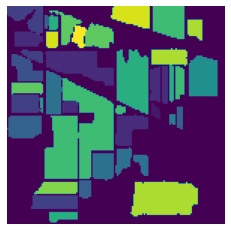

In [19]:
import matplotlib.pyplot as plt 
plt.imshow(y_pred)
plt.axis("off");

In [20]:
np.save("y_pred_cnn2d",y_pred)

(-0.5, 144.5, 144.5, -0.5)

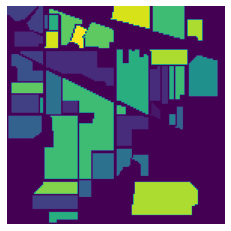

In [21]:
plt.imshow(labels)
plt.axis("off")

In [22]:
from sklearn.metrics import accuracy_score
a=y_pred.reshape(H*W)
b=labels.reshape(H*W)
cohen_kappa_score(a,b)

0.981027902310935

In [23]:
accuracy_score(a,b)

0.9865398335315101

In [24]:
from keras.metrics import MeanIoU 
n_classes=17
IOU_mean=MeanIoU(num_classes=n_classes)
IOU_mean.update_state(y_pred,labels)
print("Mean IoU",IOU_mean.result().numpy())
np.save("IoU_cnn2d",IOU_mean.result().numpy())

Mean IoU 0.96106136


In [25]:
# IoU por clase.
from keras.metrics import IoU
clases=["unlabeled","ALFALFA","CORN-NOTILL","CORN_MINTILL","CORN","GRASS-PASTURE","GRASS_TREES","GRASS_PASTURE_MOWED","HAY_WINDROWED","OATS","SOYBEAN_NOTILL","SOYBEAN-MINTILL","SOYBEAN_CLEAN","WHEAT","WOODS","BUILDING_GRASS_TREES_DRIVES","STONE_STEEL_TOWERS"]
IoU_class_report=[]
for i in range(17):
    IoU_class=IoU(num_classes=17,target_class_ids=[i])
    IoU_class.update_state(y_pred,labels)
    IoU_class_report.append(IoU_class.result().numpy())
    print(clases[i],":", IoU_class.result().numpy())

unlabeled : 0.9747312
ALFALFA : 0.9375
CORN-NOTILL : 0.9737931
CORN_MINTILL : 0.9525463
CORN : 0.9832636
GRASS-PASTURE : 0.96767676
GRASS_TREES : 0.95888597
GRASS_PASTURE_MOWED : 0.96428573
HAY_WINDROWED : 0.9979123
OATS : 0.9
SOYBEAN_NOTILL : 0.96478873
SOYBEAN-MINTILL : 0.98747474
SOYBEAN_CLEAN : 0.9483333
WHEAT : 0.9854369
WOODS : 0.97723705
BUILDING_GRASS_TREES_DRIVES : 0.9622166
STONE_STEEL_TOWERS : 0.9019608


In [26]:
np.save("reporte_IoU_cnn2d",IoU_class_report)

In [27]:
from keras.metrics import IoU
clases=["UNLABELED","ALFALFA","CORN-NOTILL","CORN_MINTILL","CORN","GRASS-PASTURE","GRASS_TREES","GRASS_PASTURE_MOWED","HAY_WINDROWED","OATS","SOYBEAN_NOTILL","SOYBEAN-MINTILL","SOYBEAN_CLEAN","WHEAT","WOODS","BUILDING_GRASS_TREES_DRIVES","STONE_STEEL_TOWERS"]
IoU_class_report=[]
for i in range(n_clases):
    IoU_class=IoU(num_classes=n_clases,target_class_ids=[i])
    IoU_class.update_state(y_pred,labels)
    IoU_class_report.append(IoU_class.result().numpy())
    print(IoU_class.result().numpy())

0.9747312
0.9375
0.9737931
0.9525463
0.9832636
0.96767676
0.95888597
0.96428573
0.9979123
0.9
0.96478873
0.98747474
0.9483333
0.9854369
0.97723705
0.9622166
0.9019608
